# Training Deep InfoMAX

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from torch import nn, optim
from models import Discriminator, MINE, Encoder
from utils import STLDataLoader, visualize_feature_vector
from settings import *
from IPython.display import clear_output

In [3]:
EPOCHS = 100
ETA = 1e-2

In [4]:
train_loader = STLDataLoader(BATCH_SIZE, mode="train")
valid_loader = STLDataLoader(BATCH_SIZE, mode="valid")

Number of data samples is 5000
Number of data samples is 8000


In [5]:
encoder = Encoder().cuda()
disc = Discriminator().cuda()
mine = MINE().cuda()

In [6]:
# encoder.load_state_dict(torch.load("./ckpts/encoder.pt"))
# mine.load_state_dict(torch.load("./ckpts/mine.pt"))
# disc.load_state_dict(torch.load("./ckpts/disc.pt"))

In [7]:
bce_criterion = nn.BCELoss()
mae_criterion = nn.L1Loss()

optimizer_enc = optim.Adam(
    [
        *encoder.parameters(),
        *mine.parameters(),
    ],
    lr=ETA
)
optimizer_disc = optim.Adam(
    disc.parameters(),
    lr=ETA
)

In [8]:
def train_step(x):
    N = x.size(0)
    
    local_features, global_features = encoder(x)
    mi = mine(local_features, global_features)
    d_fake = disc(global_features)
    
    loss_enc = -mi + bce_criterion(d_fake, torch.ones(N,).cuda())
    
    optimizer_enc.zero_grad()
    loss_enc.backward(retain_graph=True)
    optimizer_enc.step()
    
    d_real = disc(torch.randn_like(global_features).cuda())
    d_fake = disc(global_features.detach())
    
    loss_disc = bce_criterion(d_fake, torch.zeros(N,).cuda()) + bce_criterion(d_real, torch.ones(N,).cuda())
    
    optimizer_disc.zero_grad()
    loss_disc.backward()
    optimizer_disc.step()
    
    loss = loss_enc.item()
    
    return loss

In [9]:
def test_step(x):
    N = x.size(0)
    
    with torch.no_grad():
        local_features, global_features = encoder(x)
        mi = mine(local_features, global_features)

        d_fake = disc(global_features)

        loss_enc = -mi + bce_criterion(d_fake, torch.ones(N,).cuda())
        loss = loss_enc.item()
    
    return loss

In [10]:
def train():
    train_losses = []
    test_losses = []
    
    for e in range(EPOCHS):
        train_loss = 0
        test_loss = 0
        
        encoder.train()
        disc.train()
        mine.train()
        
        for x, _ in train_loader:
            x = torch.FloatTensor(x).cuda()
            train_loss += train_step(x)
        
        encoder.eval()
        disc.eval()
        mine.eval()
            
        for x, _ in valid_loader:
            x = torch.FloatTensor(x).cuda()
            test_loss += test_step(x)
            
        train_loss /= len(train_loader)
        test_loss /= len(valid_loader)
        
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        
        if e == 0 or (e+1)%20 == 0:
            clear_output(wait=True)

            print(f"Epochs {e+1}/{EPOCHS}")
            print(f"Train loss: {train_loss:.6f}, valid loss: {test_loss:.6f}")

            torch.save(encoder.state_dict(), "./ckpts/encoder.pt")
            torch.save(mine.state_dict(), "./ckpts/mine.pt")
            torch.save(disc.state_dict(), "./ckpts/disc.pt")

            plt.figure(figsize=(8, 4))

            plt.subplot(1, 2, 1)
            plt.plot(train_losses)
            plt.subplot(1, 2, 2)
            plt.plot(test_losses)
            plt.show()

Epochs 100/100
Train loss: 4.825712, valid loss: 4.851361


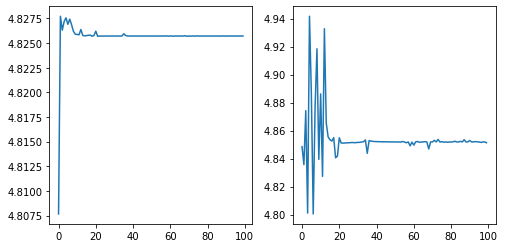

In [11]:
train()

# Visualizing Learned Representation w.r.t Labels

In [12]:
def visualize(dataloader):
    with torch.no_grad():
        plt.figure(figsize=(6, 6))
        x, y = next(iter(dataloader))
        x = torch.FloatTensor(x).cuda()
        y = torch.LongTensor(y).cuda()
        local_features, global_features = encoder(x)
        
        plt.title("Local Feature Vectors")
        visualize_feature_vector(local_features, y)


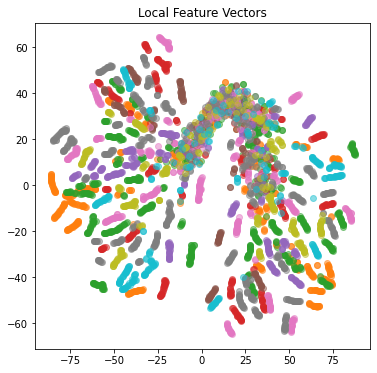

In [13]:
visualize(train_loader)

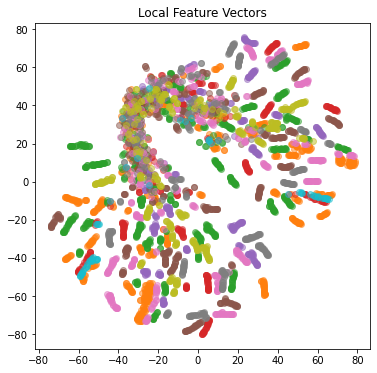

In [14]:
visualize(valid_loader)